In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

###### Создаём набор данных - имитируем сведения о заработной плате 100 менеджеров проектов. Задача - создать модель для предсказания зарплаты.

Задаем следующие данные:

1. Возраст
2. Пол
3. Количество детей
4. Опыт работы
5. Наличие сертификации
6. Предметная область
7. Число завершенных проектов


In [2]:
n_samples = 100

# Возраст
age = np.random.choice(20, n_samples) + 21
# Пол
gender = np.random.choice(('male','female'), n_samples)
# Количество детей
children = np.random.choice(3, n_samples)
# Опыт работы
work_experience = np.random.choice(15, n_samples)
# Наличие сертификации
certification = np.random.choice((0,1), n_samples)
# Предметная область
industry = np.random.choice(('banking','retail','telecom','other'), n_samples)
# Число завершенных проектов
completed_projects = np.random.choice(5, n_samples)

Заработную плату зададим как сумму параметров с коэффициентами
(это должно явно подходить для линейной регресии)
В качестве примера зададим следующие коэффициенты:
1) Базовый уровень (з/п выпусника ВУЗа) - 20000 руб
2) Каждый год опыта (от 1 до 15) оценим в +2000р
3) Прохождение сертификации: +5000р
4) Число выполненных проектов от начала до конца: +3000р
5) Предметная область (бэкграунд):
 - Банковская сфера (будем считать, что это ценится на рынке больше всего): +5000р
 - Телеком: +2000р
 - Ритейл: +0р (считаем, что это является "стандартным уровнем")
 - Остальные: -1000р (будем считать, что опыт в остальных индустриях скорее является недостатком)

In [3]:
salary = 20000 + work_experience * 2000 + certification * 5000 + completed_projects * 3000 + (industry == 'banking')* 5000 + (industry == 'telecom')* 2000 + (industry == 'other')* (-1000)           

# Генерируем данные
data = pd.DataFrame({'age': age, 'gender': gender, 'children': children, 'work_experience': work_experience,
                    'certification': certification, 'industry': industry, 'completed_projects': completed_projects,
                    'salary': salary})
data

,age,gender,children,work_experience,certification,industry,completed_projects,salary
0,21,male,1,5,0,other,2,35000
1,35,male,1,2,0,telecom,0,26000
2,23,female,0,12,1,other,2,54000
3,39,female,1,4,1,banking,3,47000
4,29,female,2,0,1,telecom,2,33000
...,...,...,...,...,...,...,...,...
95,24,male,0,10,0,retail,1,43000
96,22,female,2,0,0,telecom,4,34000
97,33,male,2,10,0,retail,3,49000
98,24,male,0,10,1,banking,0,50000


Задаем параметры модели - для начала используем все цифровые значения

In [4]:
X = data[['age', 'children', 'work_experience', 'certification', 'completed_projects']]
y = data['salary']
reg = LinearRegression().fit(X, y)
print('Weights: {}'.format(reg.coef_))
print('Bias: {}'.format(reg.intercept_))

pred_values = reg.predict(data[['age', 'children', 'work_experience', 'certification', 'completed_projects']])
print('Error: {}'.format(mean_absolute_error(pred_values, y)))
# Получаем в целом неплохую точность

Weights: [  26.44689929 -403.23650337 2054.19278507 4937.8491419  3115.94442695]
Bias: 20167.12958941908
Error: 1830.827954977838


Если бы мы исследовали данные без знания реальной зависимости,
можно было бы проверить по матрице корреляций, какие параметры влияют наибольшим образом

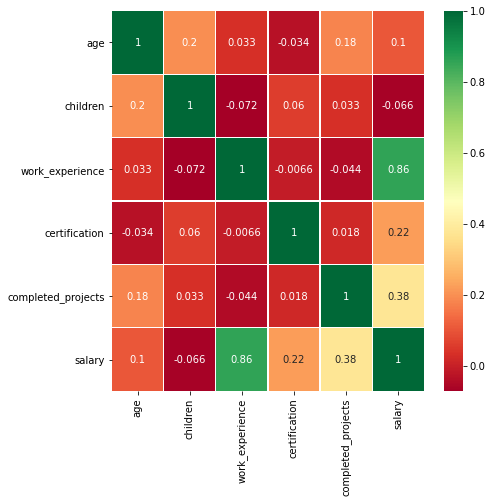

In [5]:
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(7,7)
plt.show()

Возраст и количество детей даже на матрице выглядят не очень значимыми.
А кроме того, мы понимаем, что в данном примере они ни при чем.
Уберем ненужные значения - возраст и количество детей

In [6]:
X = data[['work_experience', 'certification', 'completed_projects']]
y = data['salary']
reg = LinearRegression().fit(X, y)
print('Weights: {}'.format(reg.coef_))
print('Bias: {}'.format(reg.intercept_))

pred_values = reg.predict(data[['work_experience', 'certification', 'completed_projects']])
print('Error: {}'.format(mean_absolute_error(pred_values, y)))

Weights: [2060.89584158 4885.04041614 3129.03580126]
Bias: 20518.526402993324
Error: 1862.6020489817636


Точность предсказания повысиласть, а кроме того коэффициены стали гораздо ближе к фактическим

Попробуем еще использовать категориальные параметры.
Пол не будем трогать сейчас (хотя с данными из реальной жизни, это могло бы иметь значение).
А параметр "предметная область" трансформируем в отдельные поля-признаки (ONE-HOT Encoding).  

In [7]:
def industry_banking(industry):
    if industry == 'banking':
        return 1.0
    else:
        return 0.0
    
def industry_telecom(industry):
    if industry == 'telecom':
        return 1.0
    else:
        return 0.0

def industry_retail(industry):
    if industry == 'retail':
        return 1.0
    else:
        return 0.0
    
def industry_other(industry):
    if industry == 'other':
        return 1.0
    else:
        return 0.0
        
    
data['industry_banking'] = data['industry'].apply(industry_banking)
data['industry_telecom'] = data['industry'].apply(industry_telecom)
data['industry_retail'] = data['industry'].apply(industry_retail)
data['industry_other'] = data['industry'].apply(industry_other)
data

,age,gender,children,work_experience,certification,industry,completed_projects,salary,industry_banking,industry_telecom,industry_retail,industry_other
0,21,male,1,5,0,other,2,35000,0.0,0.0,0.0,1.0
1,35,male,1,2,0,telecom,0,26000,0.0,1.0,0.0,0.0
2,23,female,0,12,1,other,2,54000,0.0,0.0,0.0,1.0
3,39,female,1,4,1,banking,3,47000,1.0,0.0,0.0,0.0
4,29,female,2,0,1,telecom,2,33000,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,24,male,0,10,0,retail,1,43000,0.0,0.0,1.0,0.0
96,22,female,2,0,0,telecom,4,34000,0.0,1.0,0.0,0.0
97,33,male,2,10,0,retail,3,49000,0.0,0.0,1.0,0.0
98,24,male,0,10,1,banking,0,50000,1.0,0.0,0.0,0.0


Добавим новые поля в модель и запустим расчет

In [8]:
X = data[['work_experience', 'certification', 'completed_projects',
          'industry_banking', 'industry_telecom', 'industry_retail', 'industry_other']]
y = data['salary']

reg = LinearRegression().fit(X, y)
print('Weights: {}'.format(reg.coef_))
print('Bias: {}'.format(reg.intercept_))

pred_values = reg.predict(data[['work_experience', 'certification', 'completed_projects',
                                'industry_banking', 'industry_telecom', 'industry_retail', 'industry_other']])

print('Error: {}'.format(mean_absolute_error(pred_values, y)))

Weights: [ 2000.  5000.  3000.  3500.   500. -1500. -2500.]
Bias: 21500.000000000004
Error: 2.3283064365386963e-12


Точность стала практически абсолютной, но есть вопрос по коэффициентам, связанным с предметной областью.
Они неверно подсчитались, что не совсем корректно с точки зрения рекомендаций, которые можно было бы сделать
на основе модели.

Удачным решением становится удаление параметра "ритейл" - находятся точные значения коэффициентов

In [10]:
X = data[['work_experience', 'certification', 'completed_projects',
          'industry_banking', 'industry_telecom', 'industry_other']]

y = data['salary']
reg = LinearRegression().fit(X, y)
print('Weights: {}'.format(reg.coef_))
print('Bias: {}'.format(reg.intercept_))

pred_values = reg.predict(data[['work_experience', 'certification', 'completed_projects',
                                'industry_banking', 'industry_telecom', 'industry_other']])

print('Error: {}'.format(mean_absolute_error(pred_values, y)))

Weights: [ 2000.  5000.  3000.  5000.  2000. -1000.]
Bias: 19999.99999999999
Error: 1.7462298274040222e-12


Интересно, что модель хорошо сработала, когда мы убрали параметр с нулевым влиянием на результат.
Возможно каким-то образом записи с предментной областью "ритейл" стали неким "базовым вариантом",
относительно которого модель искала повышения и понижения.